# Jav: Initial EDA for GTFS data

### a. background

**What is GTFS?**
>GTFS (General Transit Feed Specification) is an open, standardized format developed by Google in 2005 for sharing public transit data, including schedules, routes, and geographic information. It's widely used by transit agencies, apps (e.g., Google Maps, Transit), and developers to model bus, rail, ferry, and other services. A GTFS feed is typically a ZIP file containing CSV tables that interconnect via unique IDs, allowing queries like "find all stops on a route" or "get arrival times for a trip."

**Digital Matatus Dataset**

The Digital Matatus project is an open-source initiative by MIT and local partners that mapped Nairobi's informal matatu (minibus) transit system, collecting data on 135 routes, 4,000+ stops, and schedules. Released as GTFS in 2019, it powers mobile apps, transit maps, and urban mobility research for Kenya's busiest public transport network.

**Source & Download**: [Digital Matatus Official Site](https://digitalmatatus.com/) (GTFS feed available via [OpenAfrica](https://bulk.openafrica.net/id/dataset/gtfs-data-on-public-transport-matatu-routes)).

### b. libraries

In [2]:
import pandas as pd
import numpy as np
import gtfs_kit as gk
import geopandas as gp
from gtfs_kit import cleaners  # for cleaning functions
from gtfs_kit import miscellany  # for quality assessment
import matplotlib.pyplot as plt
import folium  # for interactive maps
from gtfs_kit import routes  # for route-specific functions

### c. read GTFS data

GTFS feed contains the following tables
1. agency.txt
2. calendar.txt
3. calendar_dates.txt
4. feed_info.txt
5. frequencies.txt
6. routes.txt
7. shapes.txt
8. stop_times.txt
9. stops.txt
10. trips.txt

In [3]:
feed_path = '/home/dataopske/Desktop/jav/data/raw/digitalmatatu/GTFS_FEED_2019.zip'
feed = gk.read_feed(feed_path,dist_units='km')

### d. validation and cleaning

step 1: validate GTFS data

In [4]:
# Assess quality (like validation): Checks for issues like missing shapes or unused stops
quality_results = miscellany.assess_quality(feed)
print("Feed Quality Indicators:")
print(quality_results)  # DataFrame with metrics like 'num_routes', 'num_trips_missing_shapes', etc.

# Clean the feed: Applies ID cleaning, time formatting, route name fixes, and drops zombies
feed = cleaners.clean(feed)  # Comprehensive: Includes drop_zombies internally

# Quick health check (post-cleaning)
print(f"\nFeed validity period: {feed.feed_info.feed_start_date} to {feed.feed_info.feed_end_date}")
print(f"Number of routes: {len(feed.routes)}")
print(f"Number of stops: {len(feed.stops)}")
print(f"Number of trips: {len(feed.trips)}")

Feed Quality Indicators:
                             indicator                    value
0     num_route_short_names_duplicated                        0
1    frac_route_short_names_duplicated                      0.0
2          num_stop_time_dists_missing                     7533
3         frac_stop_time_dists_missing                        1
4            num_direction_ids_missing                        0
5           frac_direction_ids_missing                      0.0
6             num_trips_missing_shapes                        0
7            frac_trips_missing_shapes                      0.0
8          num_departure_times_missing                        0
9         frac_departure_times_missing                      0.0
10   num_first_departure_times_missing                        0
11  frac_first_departure_times_missing                      0.0
12    num_last_departure_times_missing                        0
13   frac_last_departure_times_missing                      0.0
14             

step 2: explore the structures and metadata of the GTFS feed

In [5]:
# Get available tables
tables = [attr for attr in dir(feed) if hasattr(getattr(feed, attr), 'head')]
for table in tables:
    df = getattr(feed, table)
    if df is not None:
        print(f"{table}: {len(df)} rows, {len(df.columns)} columns")
df.head()

agency: 1 rows, 6 columns
calendar: 1 rows, 10 columns
calendar_dates: 4 rows, 3 columns
feed_info: 1 rows, 5 columns
frequencies: 792 rows, 4 columns
routes: 136 rows, 5 columns
shapes: 36483 rows, 4 columns
stop_times: 7533 rows, 5 columns
stops: 4284 rows, 6 columns
trips: 272 rows, 6 columns


route_id service_id   trip_id trip_headsign  direction_id  shape_id
0  10000107D11      DAILY  1107D110         Ruaka             0  1107D110
1  10000107D11      DAILY  1107D111         Ruiru             1  1107D111
2  10000114011      DAILY  10114110         Ngara             0  10114110
3  10000114011      DAILY  10114111        Limuru             1  10114111
4  10000116011      DAILY  10116110          Koja             0  10116110

step 3. basic descriptive statistics

a. route overview

In [6]:
# Merge trips with routes for richer stats
routes_trips = feed.trips.merge(feed.routes[['route_id', 'route_short_name', 'route_type']], on='route_id')
route_stats = routes_trips.groupby('route_short_name').agg({
    'trip_id': 'count',  # Trips per route
    'route_type': 'first'
}).rename(columns={'trip_id': 'num_trips'}).sort_values('num_trips', ascending=False)
route_stats.head(10) # Top 10 busiest routes

num_trips  route_type
route_short_name                       
0027                      2           3
0039                      2           3
0048                      2           3
046P                      2           3
1                         2           3
10                        2           3
100                       2           3
100A                      2           3
102                       2           3
103                       2           3

b. stop coverage

In [7]:
print(f"Avg stops per route: {feed.stops.shape[0] / len(feed.routes):.1f}")
# Spatial summary (if GeoPandas works)
print(feed.stops[['stop_lat', 'stop_lon']].describe())

Avg stops per route: 31.5
          stop_lat     stop_lon
count  4284.000000  4284.000000
mean     -1.272630    36.824196
std       0.058602     0.081633
min      -1.477218    36.629579
25%      -1.303790    36.765932
50%      -1.275724    36.827780
75%      -1.247147    36.887114
max      -1.035427    37.076427


c. schedule basics

In [8]:
# Service days from calendar
service_days = feed.calendar[['service_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum()
print("Service by day of week:", service_days)

Service by day of week: service_id    DAILY
monday            1
tuesday           1
wednesday         1
thursday          1
friday            1
saturday          1
sunday            1
dtype: object


### e. table by table EDA

#### 1. agency

- basic info on the transit agency(ies) providing service, e.g., agency name, URL, timezone, contact phone. (Usually 1+ rows, one per agency.)

In [9]:
agency = feed.agency
agency.head()

agency_id                                        agency_name  \
0       UON  Approved SACCOs - University of Nairobi C4D La...   

                      agency_url agency_timezone agency_lang   agency_phone  
0  http://www.digitalmatatus.com  Africa/Nairobi          en  020 - 2729200

#### 2. calendar

- Defines service patterns for groups of trips by day-of-week (e.g., monday=1, tuesday=1 for weekdays), plus start/end dates. Used for regularly scheduled services.

In [10]:
cal = feed.calendar
cal.head()

service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0      DAILY       1        1          1         1       1         1       1   

  start_date  end_date  
0   20190101  20201231

In [11]:
cal.shape

(1, 10)

#### 3. calendar dates

- Exceptions to calendar.txt, e.g., added/removed service dates for holidays or events (service_id, date, exception_type=1 for added, 2 for removed).

In [12]:
cal_dates = feed.calendar_dates
cal_dates

service_id      date  exception_type
0      DAILY  20191020               1
1      DAILY  20191212               1
2      DAILY  20201020               1
3      DAILY  20201212               1

#### 4. feed info

- Metadata about the entire feed, e.g., feed publisher, version, start/end validity dates, contact email. (Typically 1 row.)

In [13]:
info = feed.feed_info
info.head()

feed_publisher_name              feed_publisher_url feed_lang  \
0            TRAINING  http://www.digitalmatatus.com/        en   

  feed_start_date feed_end_date  
0        20120302      20201231

#### 5. frequencies

- Headways (time intervals) for high-frequency trips without fixed schedules, e.g., every 10 minutes from 7 AM (trip_id, start_time, end_time, headway_secs).

In [14]:
freqs = feed.frequencies
freqs.head()

trip_id start_time  end_time  headway_secs
0  10106110   06:00:00  09:00:00           300
1  10106110   09:00:00  15:00:00           900
2  10106110   15:00:00  21:00:00           300
3  10106111   06:00:00  09:00:00           300
4  10106111   09:00:00  15:00:00           900

#### 6. routes

- Details on routes, e.g., route_id, short/long names, type (bus=3, rail=2), agency_id, color. Acts as a high-level grouping for trips.

In [15]:
routes = feed.routes
routes.head(5)

route_id agency_id route_short_name                 route_long_name  \
0  10000107D11       UON             107D                     Ruaka-Ruiru   
1  10000114011       UON             114R     Ngara-Rwaka-Ndenderu-Limuru   
2  10000116011       UON              116        Koja-Ngara-Banana-Limuru   
3  10100011A11       UON              11A        Odeon-Aga Khan-Highridge   
4  10200010811       UON              108  UN-New Muthaiga-Gachie-Gichagi   

   route_type  
0           3  
1           3  
2           3  
3           3  
4           3

#### 7. shapes

Geographic paths for routes as sequences of points (shape_id, lat, lon, sequence). Optional; used for mapping curved routes.

In [16]:
shape = feed.shapes
shape.head()

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence
0  10106110     -1.173842     36.758779                  1
1  10106110     -1.174523     36.759025                  2
2  10106110     -1.175076     36.759267                  3
3  10106110     -1.175821     36.759535                  4
4  10106110     -1.176998     36.759982                  5

#### 8. stops

- Stop locations: stop_id, name, lat/lon, platform code, parent station (for grouped stops like platforms). Forms the network of points.

In [17]:
stops = feed.stops
stops.head(5)

stop_id           stop_name  stop_lat   stop_lon  location_type  \
0  0001RLW            Railways -1.290884  36.828242              0   
1  0002KOJ                Koja -1.281230  36.822596              1   
2  0003NGR               Ngara -1.274395  36.823806              1   
3  0004ODN               Odeon -1.282769  36.825032              1   
4  0005AMB  Kencom/Ambassadeur -1.285963  36.826048              1   

  parent_station  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [18]:
stops['stop_name'].value_counts()

stop_name
Tuskys                       23
Car Wash                     22
Naivas                       21
Kwa Chief                    19
Equity                       17
                             ..
Stima Sacco                   1
Mothers Mercys/GD             1
Mifereji/God's Ability        1
Donholm Interchange/Stage     1
Kwa D.O                       1
Name: count, Length: 2474, dtype: Int64

In [19]:
stops['stop_name'].nunique()

2474

#### 9. stop times

- Timetables for trips: arrival/departure times, stop sequences, distances (trip_id, stop_id, arrival_time, departure_time, stop_sequence). Core table for schedules.

In [20]:
stop_time = feed.stop_times
stop_time.head()

trip_id arrival_time departure_time  stop_id  stop_sequence
0  10106110     06:00:00       06:00:20  0110BAA              1
1  10106110     06:00:34       06:00:54  0110BNI              2
2  10106110     06:01:10       06:01:30  0110UMK              3
3  10106110     06:01:49       06:02:09  0110AEA              4
4  10106110     06:02:45       06:03:05  0100MOM              5

#### 10. trips

- Individual vehicle runs: trip_id, route_id, service_id (links to calendar), headsign (destination), shape_id, wheelchair_accessible. Bridges routes to stop_times.

In [21]:
trips = feed.trips
trips.head()

route_id service_id   trip_id trip_headsign  direction_id  shape_id
0  10000107D11      DAILY  1107D110         Ruaka             0  1107D110
1  10000107D11      DAILY  1107D111         Ruiru             1  1107D111
2  10000114011      DAILY  10114110         Ngara             0  10114110
3  10000114011      DAILY  10114111        Limuru             1  10114111
4  10000116011      DAILY  10116110          Koja             0  10116110

In [22]:
info.shape

(1, 5)

### f. visualizations

#### a. stop maps

In [23]:
import folium
from IPython.display import display

# Center map around average stop coordinates
m = folium.Map(
    location=[feed.stops.stop_lat.mean(), feed.stops.stop_lon.mean()],
    zoom_start=11,
    tiles='cartodb positron'  # clean basemap
)

# Add first 100 stops for visualization
for _, row in feed.stops.head(100).iterrows():
    folium.CircleMarker(
        location=[row.stop_lat, row.stop_lon],
        radius=3,
        popup=row.stop_name,
        color='blue',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Display inline in Jupyter
display(m)

#### b. route lengths

In [24]:
# import pandas as pd

# start, end = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
# dates = pd.date_range(start, end, freq='7D')  # every 7 days

# stats_all = [gk.compute_route_stats(feed, date=d) for d in dates]
# stats = pd.concat(stats_all)

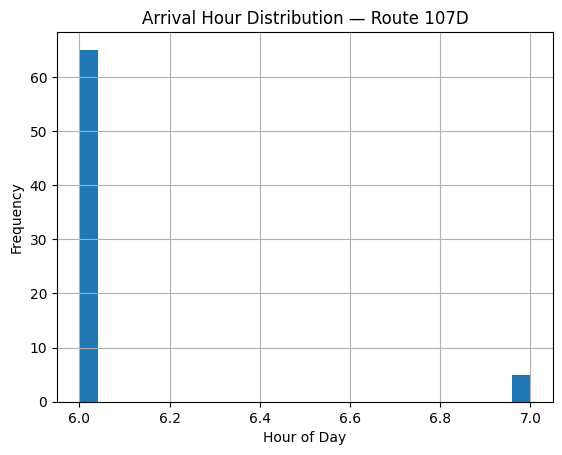

In [25]:
# Select one route
sample_route = feed.routes.route_short_name.iloc[0]

# Filter trips for that route
route_trips = feed.trips[
    feed.trips.route_id == feed.routes[feed.routes.route_short_name == sample_route].route_id.iloc[0]
]

# Get stop_times for those trips
sample_stop_times = feed.stop_times[
    feed.stop_times.trip_id.isin(route_trips.trip_id)
].copy()

# Extract hour from arrival_time safely
sample_stop_times['arrival_hour'] = pd.to_datetime(
    sample_stop_times['arrival_time'],
    format='%H:%M:%S',
    errors='coerce'
).dt.hour

# Plot histogram
sample_stop_times['arrival_hour'].hist(bins=24)
plt.title(f"Arrival Hour Distribution — Route {sample_route}")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.show()

In [26]:
# Pick a route_id
sample_route_id = feed.routes.route_id.iloc[0]
route_trips = feed.trips[feed.trips.route_id == sample_route_id].trip_id.unique()[:5]  # Sample trips
path = feed.stop_times[feed.stop_times.trip_id.isin(route_trips)].merge(
    feed.stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']], on='stop_id'
).sort_values(['trip_id', 'stop_sequence'])
path.head(20)  # Sequence of stops with times/locations

trip_id arrival_time departure_time  stop_id  stop_sequence  \
0   1107D110     06:00:00       06:00:20  0213MRY              1   
1   1107D110     06:02:39       06:02:59  0100OOA              2   
2   1107D110     06:03:26       06:03:46  0100AWA              3   
3   1107D110     06:04:18       06:04:38  0100TPS              4   
4   1107D110     06:05:25       06:05:45  0100OTN              5   
5   1107D110     06:06:57       06:07:17  0110LHL              6   
6   1107D110     06:08:43       06:09:03  0110AOH              7   
7   1107D110     06:09:33       06:09:53  0110ISR              8   
8   1107D110     06:11:59       06:12:19  0100RJI              9   
9   1107D110     06:12:40       06:13:00  0100JO.             10   
10  1107D110     06:14:26       06:14:46  0100NRP             11   
11  1107D110     06:16:12       06:16:32  0100AEL             12   
12  1107D110     06:18:20       06:18:40  0100..M             13   
13  1107D110     06:19:46       06:20:06  0100ANJ             14   
14  1107D110     06:21:53       06:22:13  0100A.P             15   
15  1107D110     06:23:52       06:24:12  0100ACP             16   
16  1107D110     06:24:46       06:25:06  0100KHR             17   
17  1107D110     06:26:11       06:26:31  0100PSA             18   
18  1107D110     06:27:25       06:27:45  0110WOJ             19   
19  1107D110     06:28:23       06:28:43  010044G             20   

                     stop_name  stop_lat   stop_lon  
0                        Ruiru -1.147669  36.959317  
1                     Kwa Soko -1.149789  36.948829  
2                     Wataalam -1.149612  36.947408  
3                         Post -1.149687  36.945525  
4                       Hilton -1.150637  36.942590  
5           Full Gospel Church -1.151018  36.937462  
6                    Mama Shop -1.151753  36.931196  
7                Ruiru Prisons -1.151871  36.929525  
8          Ruiru Road Junction -1.152105  36.919942  
9                          O.J -1.152971  36.920232  
10  Round About Eastern Bypass -1.155235  36.926119  
11               Membley Stage -1.160297  36.922367  
12                        K.M. -1.167727  36.919008  
13                 Kwa Kiwanja -1.171676  36.916509  
14                        A.P. -1.178289  36.911960  
15                        PCEA -1.184213  36.907515  
16  Kahawa Railways Roundabout -1.186098  36.906817  
17           La Philla Carwash -1.190634  36.906088  
18             Maziwa Junction -1.193992  36.904538  
19                 44 Githurai -1.195514  36.902695

In [ ]:
import folium
from gtfs_kit import routes

# Get all short names of routes
all_short_names = feed.routes['route_short_name'].dropna().tolist()

# Plot routes using gtfs_kit
m = routes.map_routes(feed, route_short_names=all_short_names)

# Manually overlay stops
for _, row in feed.stops.iterrows():
    folium.CircleMarker(
        location=[row.stop_lat, row.stop_lon],
        radius=2,
        color="blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Display interactively in notebook
m

In [ ]:
import folium
from gtfs_kit import routes

# Get all short names of routes
all_short_names = feed.routes['route_short_name'].dropna().tolist()

# Plot routes using gtfs_kit
m = routes.map_routes(feed, route_short_names=all_short_names)

# Display interactively in the notebook
m